# Permeability Prediction of Core Samples

***
##Introduction
This simple project is in compliance for the Deep Learning with PyTorch: Zero to Gans Course. Although, the dataset chosen is fairly small, I quite like it because it is something that's within my doain knowledge. 

The rock.csv file was obtained from Kaggle with no description from the uploader. Thus, I don't have any information about the methodology of measurement and specific units used in the dataset. I was continuously figuring out how to process the data throughout this whole project so bare with me. :P Thank you.

### Goal

In this simple study, we'll try to predict the Permeability of a Core Sample using the informations contained in the rock.csv dataset. The first part is focused on understanding the data and its variables using statistical analysis and visualization techniques. After that, I applied different algorithms to model permeability. Then, I will evaluate the different models established and decide which is the optimal choice to predict Permeability.

***
##Looking into the Data

In [33]:
# Installing necessary libraries
import torch
import torchvision
import torch.nn as nn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

#### The dataset

In this section, I will look through and organize the dataset.

In [16]:
# Download and read 'rock.csv'
data_url = 'https://raw.githubusercontent.com/mavsison/core-sample-permeability-prediction/master/rock.csv'
download_url(data_url, '.')
data_filename = 'rock.csv'
pd.read_csv(data_filename).head()

Using downloaded and verified file: ./rock.csv


,Unnamed: 0,area,peri,shape,perm
0,1,4990,2791.90,0.090330,6.3
1,2,7002,3892.60,0.148622,6.3
2,3,7558,3930.66,0.183312,6.3
3,4,7352,3869.32,0.117063,6.3
4,5,7943,3948.54,0.122417,17.1


In [17]:
rock = pd.read_csv(data_filename) # store the csv file as 'rock' data frame

rock.info() # to know the dataset more

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  48 non-null     int64  
 1   area        48 non-null     int64  
 2   peri        48 non-null     float64
 3   shape       48 non-null     float64
 4   perm        48 non-null     float64
dtypes: float64(3), int64(2)
memory usage: 2.0 KB


In [18]:
# Organizing the data frame
rock.rename(columns = {'area':'Area', 
                       'peri':'Perimeter', 
                       'shape':'Shape', 
                       'perm':'Permeability', 
                       'Unnamed: 0':'Core Samples'}, 
            inplace = True)
rock = rock[['Permeability', 'Shape', 'Area', 'Perimeter', 'Core Samples']]
rock.set_index('Core Samples', inplace = True)
rock.head(10)

,Permeability,Shape,Area,Perimeter
Core Samples,,,,
1,6.3,0.090330,4990,2791.90
2,6.3,0.148622,7002,3892.60
3,6.3,0.183312,7558,3930.66
4,6.3,0.117063,7352,3869.32
5,17.1,0.122417,7943,3948.54
6,17.1,0.167045,7979,4010.15
7,17.1,0.189651,9333,4345.75
8,17.1,0.164127,8209,4344.75
9,119.0,0.203654,8393,3682.04


In [19]:
# As per data information, 12 core samples was divided into four cross section to make this data set. To check this:

print('Unique permeabilities: ', rock.Permeability.unique())
print('\nNumber of cores: ', len(rock.Permeability.unique()))

Unique permeabilities:  [   6.3   17.1  119.    82.4   58.6  142.   740.   890.   950.   100.
 1300.   580. ]

Number of cores:  12


In [20]:
rock.describe() # to know basic statistical details of the data set

,Permeability,Shape,Area,Perimeter
count,48.000000,48.000000,48.000000,48.000000
mean,415.450000,0.218110,7187.729167,2682.211938
std,437.818226,0.083496,2683.848862,1431.661164
min,6.300000,0.090330,1016.000000,308.642000
25%,76.450000,0.162262,5305.250000,1414.907500
50%,130.500000,0.198862,7487.000000,2536.195000
75%,777.500000,0.262670,8869.500000,3989.522500
max,1300.000000,0.464125,12212.000000,4864.220000


The data set is fairly small with only 48 rows and 4 columns namely Permeability, Shape, Area, and Perimeter.


In [21]:
per_core = rock.groupby(rock['Permeability'], as_index=False).mean()

####Methodology

With these info, I will be checking both per cross section data (48 rows) and per core data (12 rows, mean of four cross section)

***

### Analyze the data

Let us plot the correlation between each column and see its linear relationship.

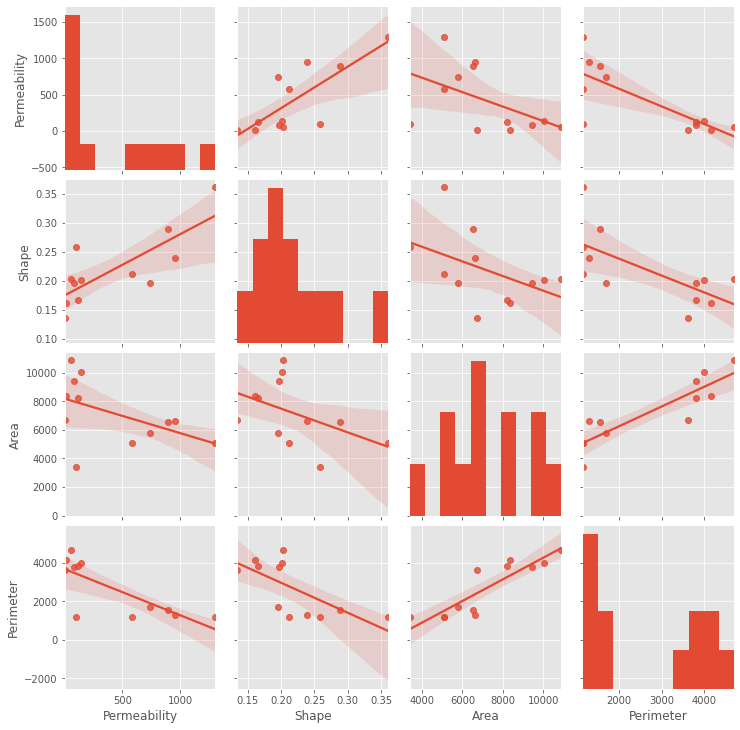

In [22]:
sns.pairplot(per_core, kind='reg')
plt.show()

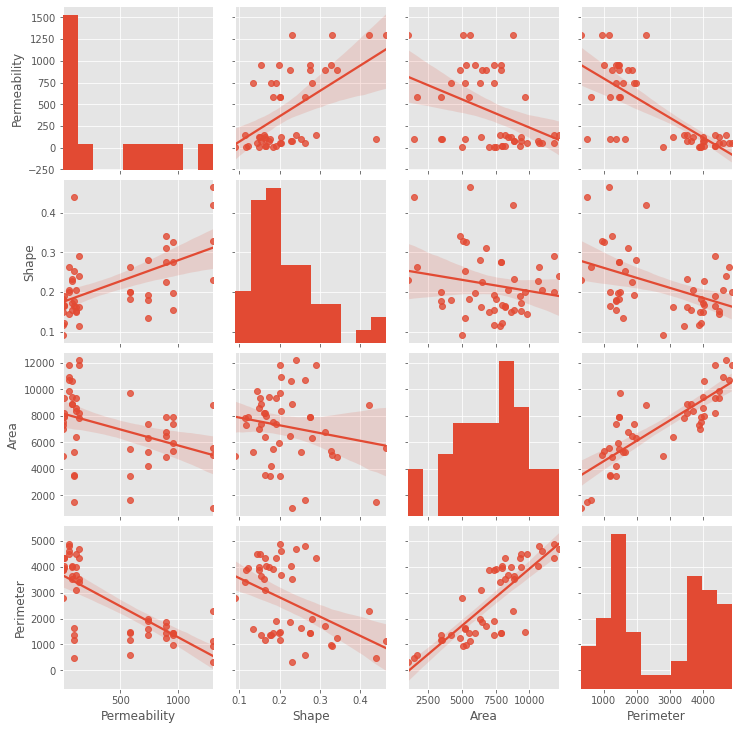

In [23]:
sns.pairplot(rock, kind='reg')
plt.show()

In [24]:
print(rock.corr())
print(per_core.corr())

              Permeability     Shape      Area  Perimeter
Permeability      1.000000  0.556721 -0.396637  -0.738716
Shape             0.556721  1.000000 -0.182161  -0.433126
Area             -0.396637 -0.182161  1.000000   0.822506
Perimeter        -0.738716 -0.433126  0.822506   1.000000
              Permeability     Shape      Area  Perimeter
Permeability      1.000000  0.779841 -0.492672  -0.768887
Shape             0.779841  1.000000 -0.458400  -0.674367
Area             -0.492672 -0.458400  1.000000   0.884444
Perimeter        -0.768887 -0.674367  0.884444   1.000000


It is interesting to see that the averaged data per core shows higher linear correlation coefficient especially those correlated to Shape. Let's take a look at the differences of the coefficients.

In [25]:
abs(per_core.corr() - rock.corr())

,Permeability,Shape,Area,Perimeter
Permeability,0.000000,0.223120,0.096035,0.030171
Shape,0.223120,0.000000,0.276239,0.241242
Area,0.096035,0.276239,0.000000,0.061937
Perimeter,0.030171,0.241242,0.061937,0.000000


#Linear Regression

In [91]:
batch_size = 8
learning_rate = 1e-9

TARGET_COLUMN = 'Permeability'
input_size= 3
output_size=1

In [92]:
inputs = rock.drop('Permeability', axis=1).values
targets = rock[['Permeability']].values
inputs.shape, targets.shape 

((48, 3), (48, 1))

In [105]:
dataset = TensorDataset(torch.tensor(inputs, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32))

train_loader = DataLoader(dataset, batch_size, shuffle=True)
val_loader = DataLoader(dataset, batch_size)

In [106]:
class PermModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch 
        out = self(inputs)                 # Generate predictions
        loss = F.mse_loss(out, targets)    # Calculate loss
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}".format(epoch, result['val_loss']))
    
model = PermModel()

In [121]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.ASGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [122]:
result = evaluate(model, val_loader)
result

{'val_loss': 115542.7265625}

In [123]:
history = fit(10000, learning_rate, model, train_loader, val_loader)

Streaming output truncated to the last 5000 lines.
Epoch [5001], val_loss: 115511.1172
Epoch [5002], val_loss: 115595.6562
Epoch [5003], val_loss: 115649.5391
Epoch [5004], val_loss: 115672.5859
Epoch [5005], val_loss: 115527.6875
Epoch [5006], val_loss: 115505.6953
Epoch [5007], val_loss: 115507.3047
Epoch [5008], val_loss: 115508.7891
Epoch [5009], val_loss: 115548.7266
Epoch [5010], val_loss: 115523.8984
Epoch [5011], val_loss: 115524.1484
Epoch [5012], val_loss: 115581.4375
Epoch [5013], val_loss: 115560.8438
Epoch [5014], val_loss: 115511.6953
Epoch [5015], val_loss: 115639.2578
Epoch [5016], val_loss: 115517.2734
Epoch [5017], val_loss: 115510.1016
Epoch [5018], val_loss: 115556.8750
Epoch [5019], val_loss: 115521.2578
Epoch [5020], val_loss: 115518.3359
Epoch [5021], val_loss: 115506.3672
Epoch [5022], val_loss: 115642.9141
Epoch [5023], val_loss: 115523.3359
Epoch [5024], val_loss: 115554.5703
Epoch [5025], val_loss: 115506.9922
Epoch [5026], val_loss: 115525.1641
Epoch [5027],

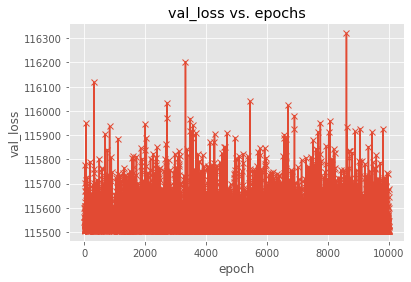

In [124]:
losses = [r['val_loss'] for r in [result] + history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('val_loss')
plt.title('val_loss vs. epochs');

In [125]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(x).item()

In [126]:
x, target = val_ds[7]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([2.7602e-01, 7.8940e+03, 1.4611e+03])
Target:  890.0
Prediction: 1032.9716796875
